In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [49]:
import warnings; warnings.simplefilter('ignore')

In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set

### Collect data

In [4]:
DATASET_ID = 'castellucci_mouse_usv_segmented'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'mouse.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/castellucci_mouse_usv_segmented/mouse.pickle')

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,22.666,22.678,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,"[0.027472521623816974, 0.33994847238139614, -0...",250000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,23.804,23.818,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,"[-0.11161248771115849, 0.36372485865519466, 0....",250000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,23.892,23.902,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,"[0.13599627793788374, 0.06537101975011975, -0....",250000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [9]:
len(syllable_df)

21834

Text(0.5, 1.0, 'min')

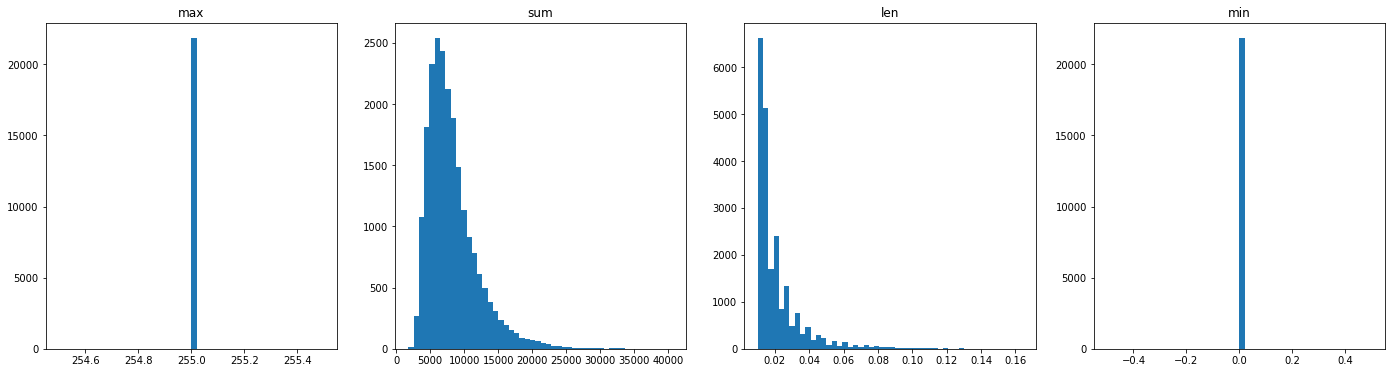

In [10]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[3].set_title('min')

### cluster

In [11]:
len(syllable_df)

21834

In [12]:
specs = list(syllable_df.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(21834, 640)

(25.0, 10) (320, 800) 25.0 32 800


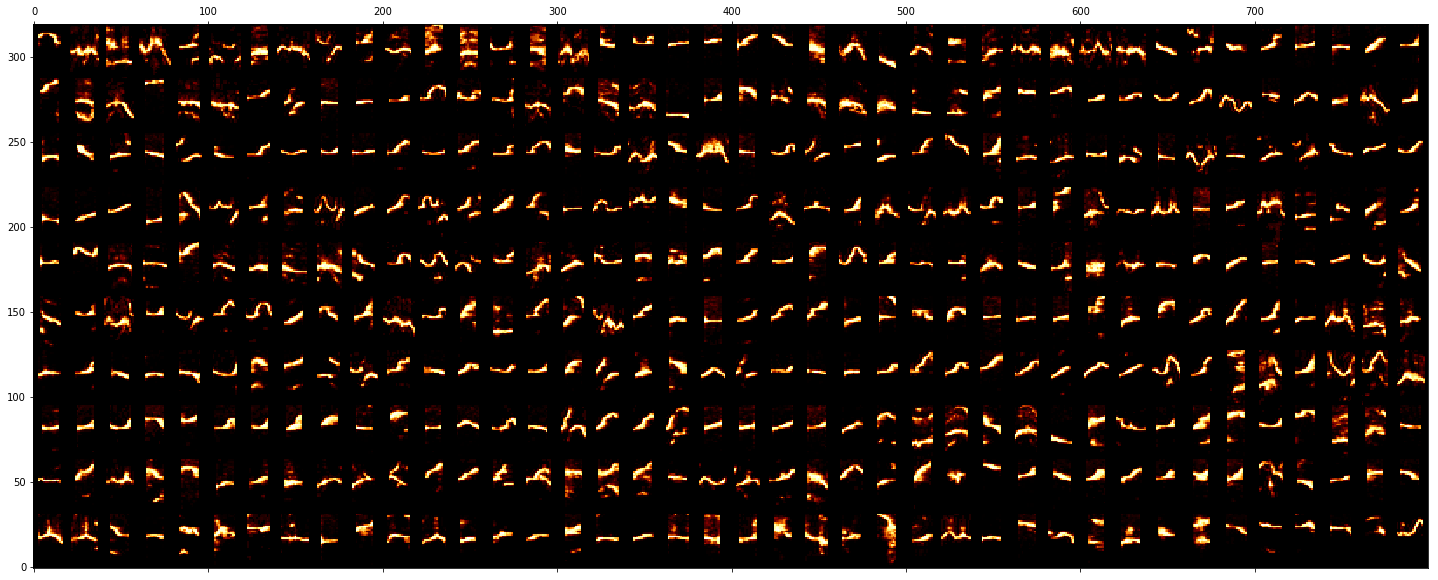

In [48]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

In [13]:
fit = umap.UMAP()

In [14]:
np.shape(specs_flattened)

(21834, 640)

In [15]:
z  = list(fit.fit_transform(specs_flattened))

In [16]:
z = np.vstack(z)

TypeError: list indices must be integers or slices, not tuple

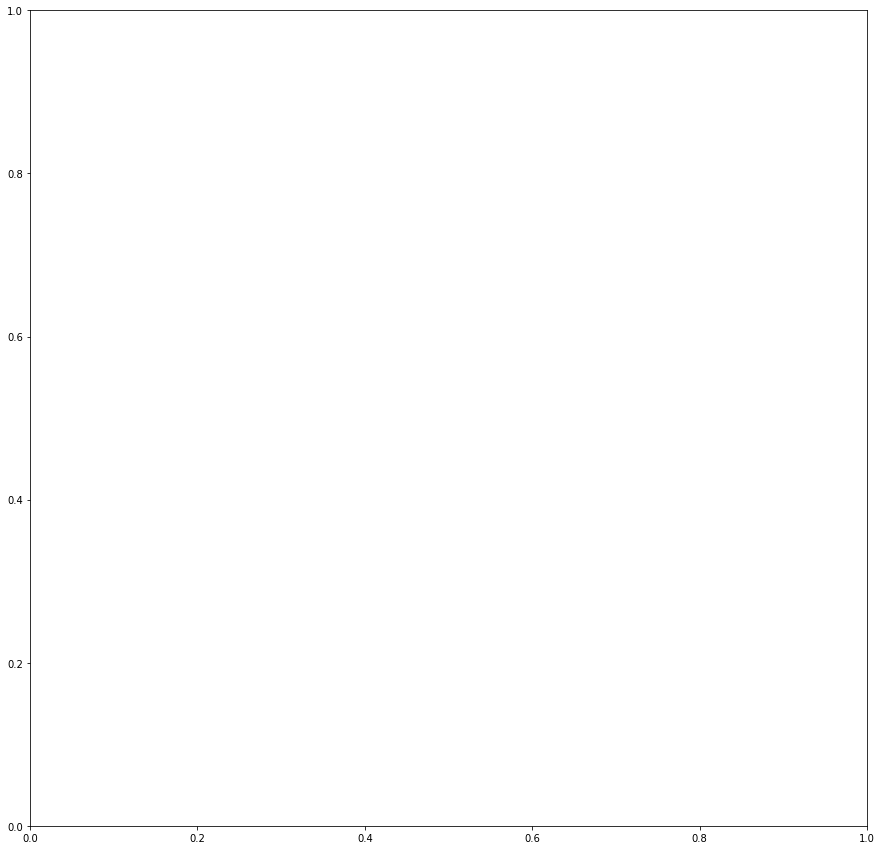

In [51]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=1, labels = syllable_df['indv'].values, s=5, ax = ax)
plt.show()

### variation across individuals

In [24]:
syllable_df.indv.unique()

array(['VOC594', 'VOC592', 'VOC591', 'VOC597'], dtype=object)

In [27]:
from avgn.visualization.quickplots import draw_projection_plots

VOC594 8302
(25.0, 10) (320, 800) 25.0 32 800


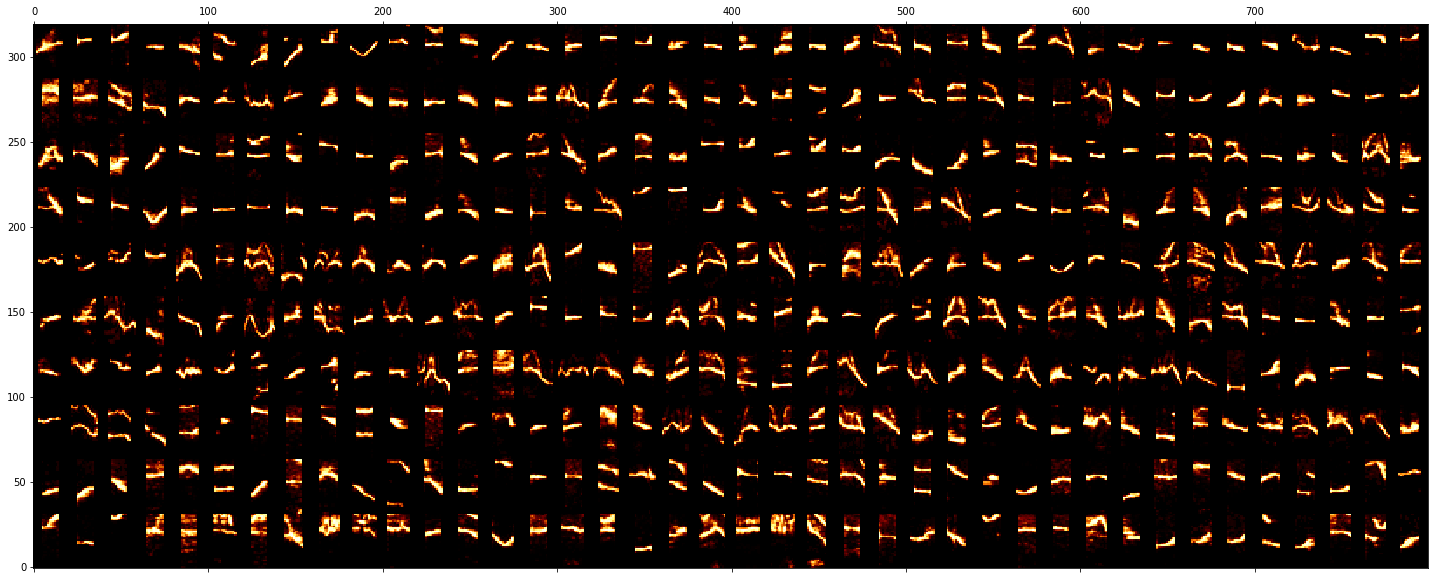

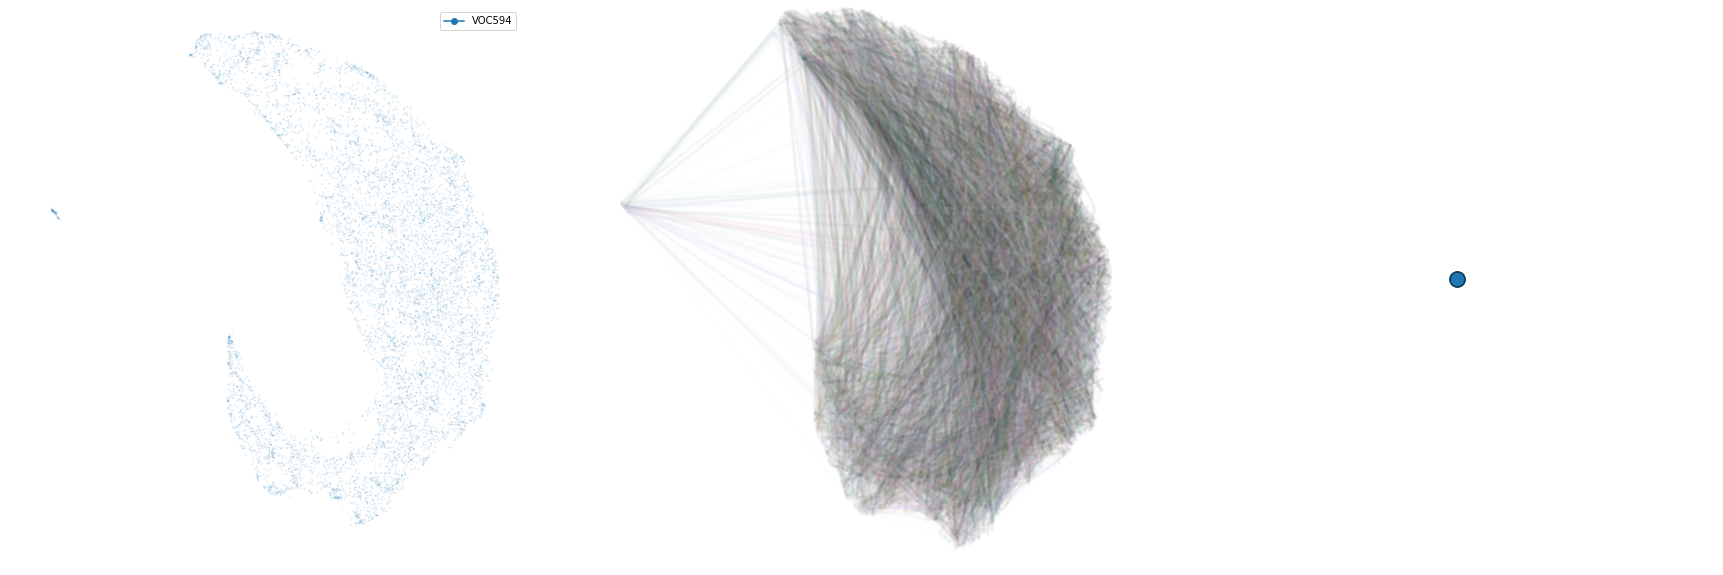

VOC592 4101
(25.0, 10) (320, 800) 25.0 32 800


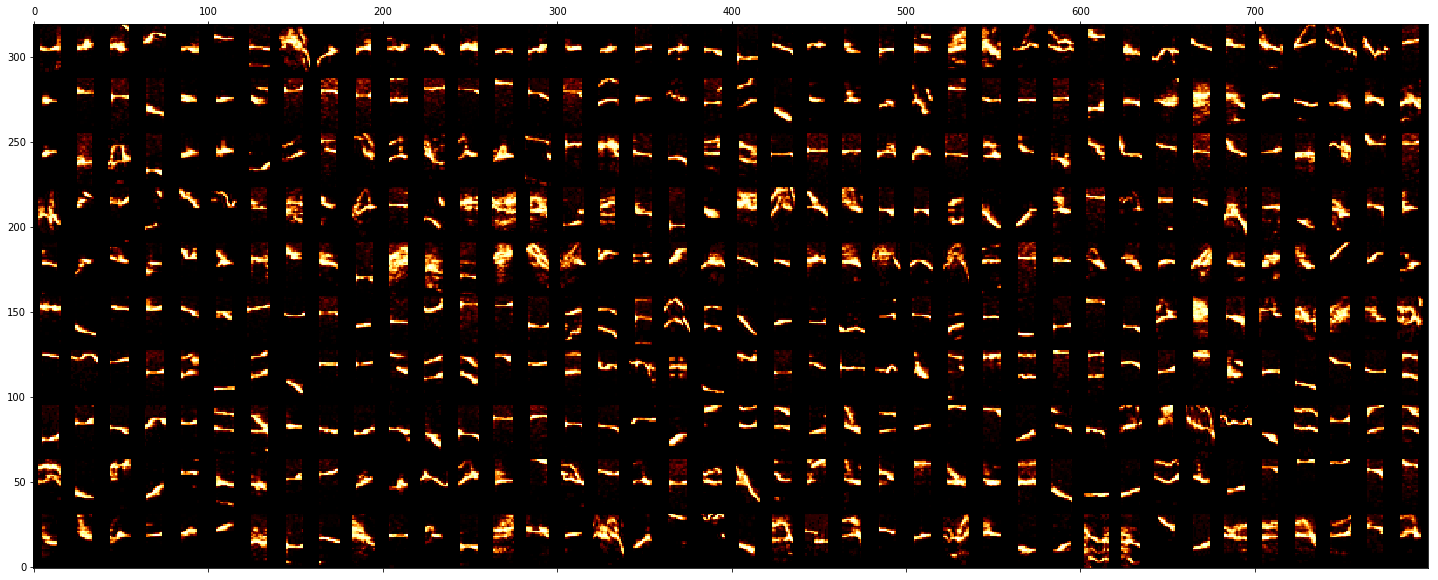

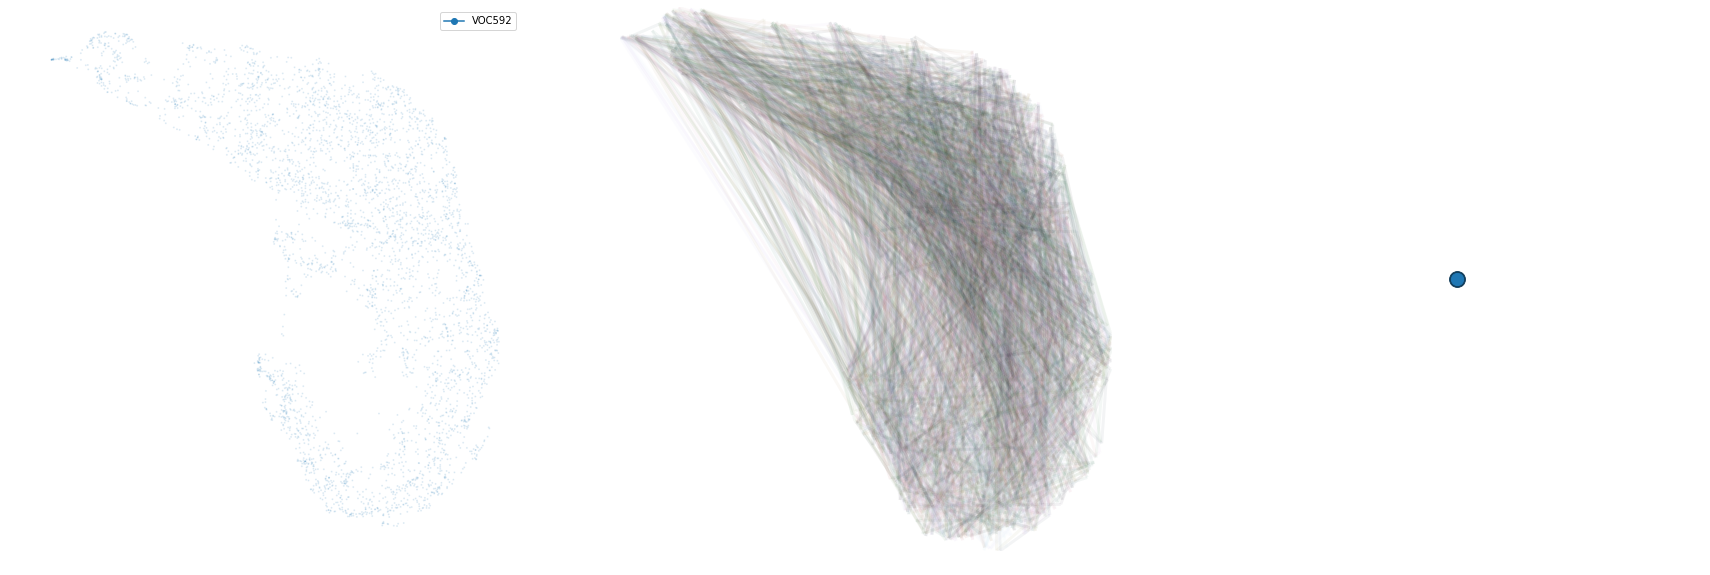

VOC591 7856
(25.0, 10) (320, 800) 25.0 32 800


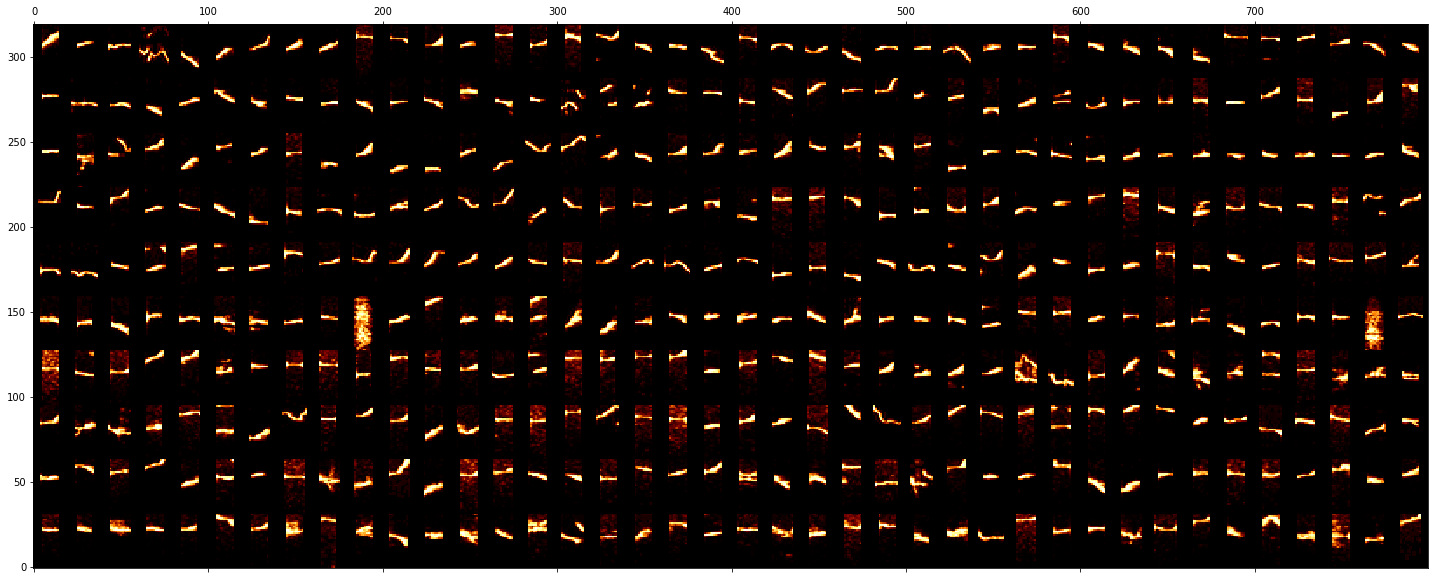

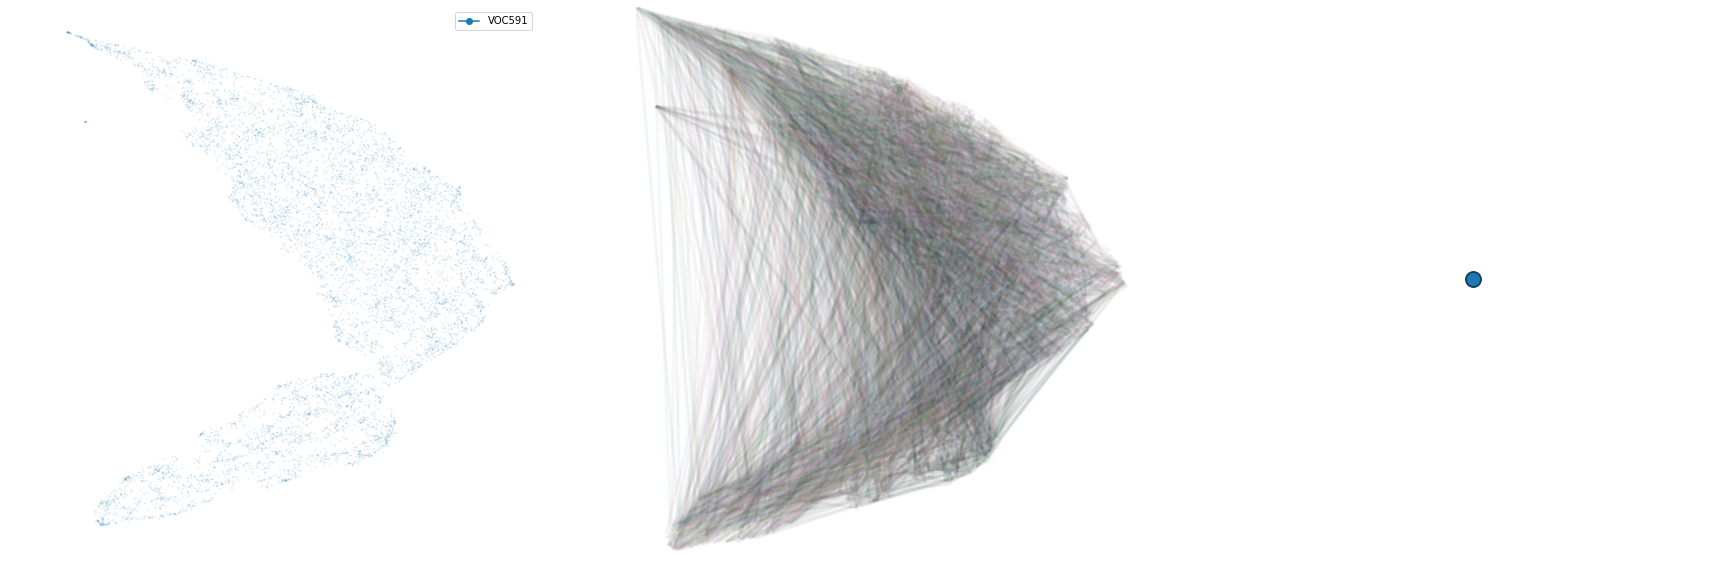

VOC597 1575
(25.0, 10) (320, 800) 25.0 32 800


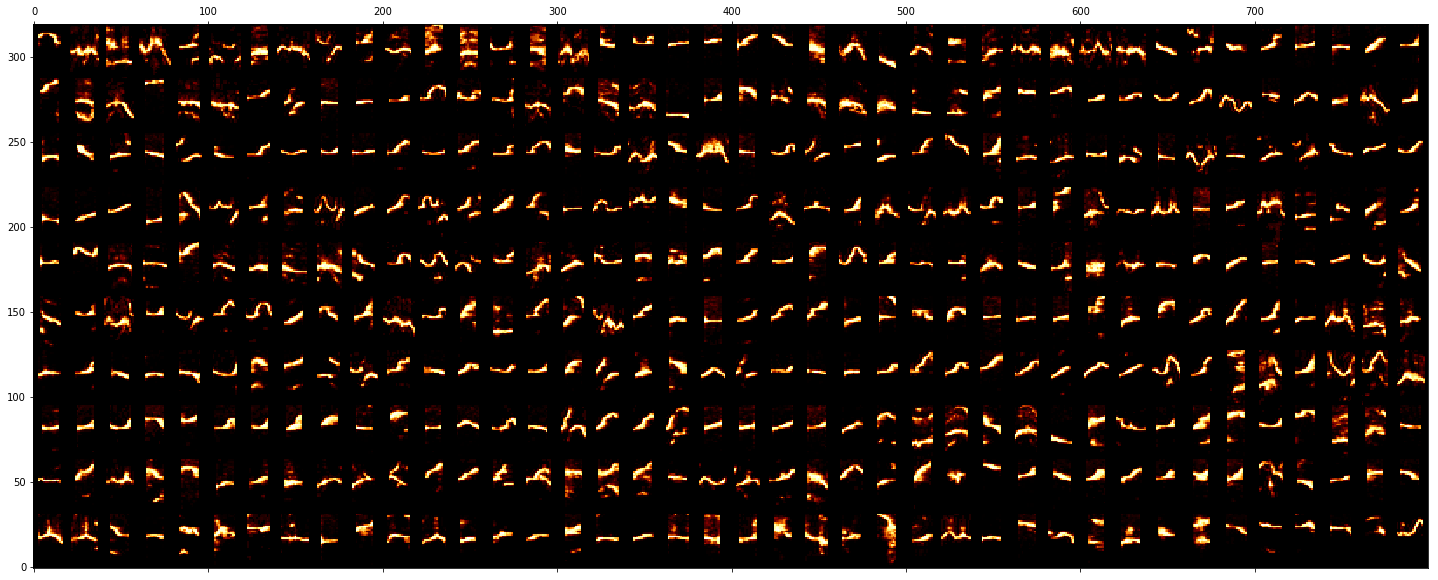

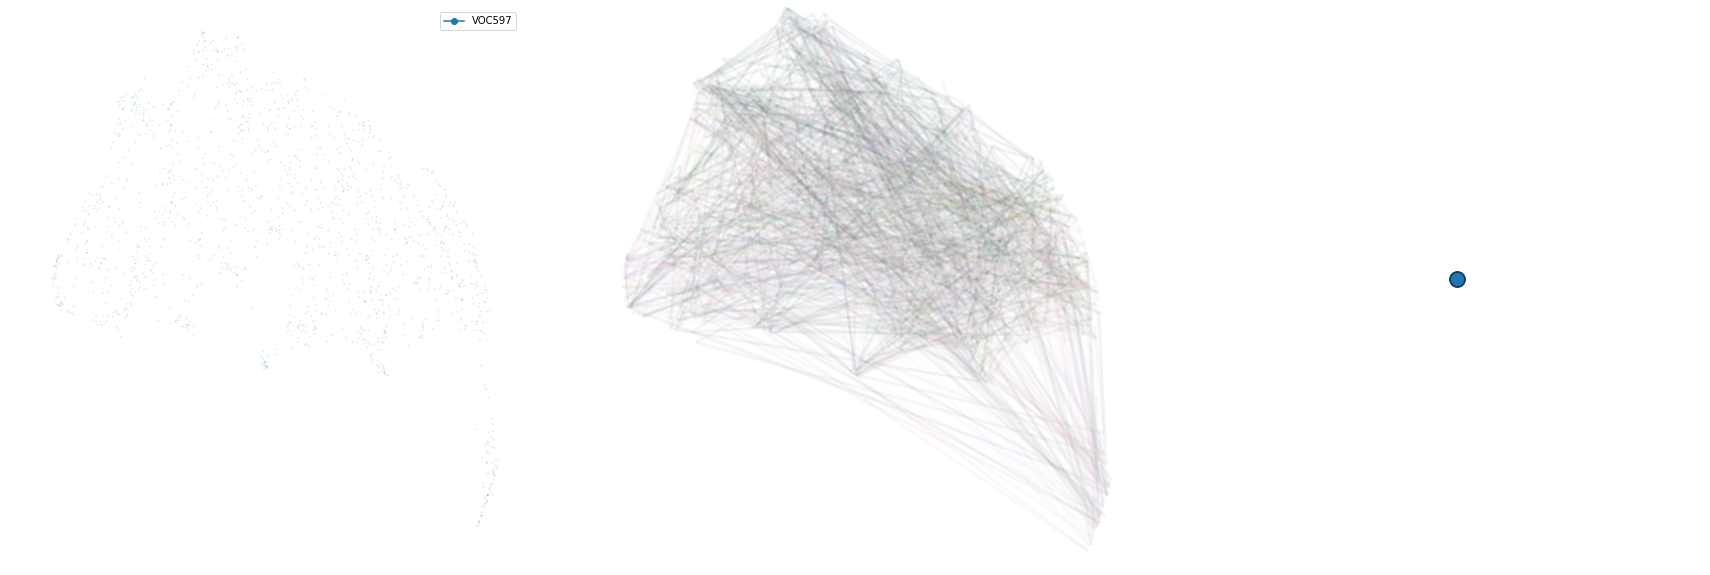

In [50]:
for indv in tqdm(syllable_df.indv.unique()):
    indv_df = syllable_df[syllable_df.indv == indv]
    print(indv, len(indv_df))

    specs = list(indv_df.spectrogram.values)
    draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)
    
    specs_flattened = flatten_spectrograms(specs)

    fit = umap.UMAP()
    z = list(fit.fit_transform(specs_flattened))
    indv_df["umap"] = z

    indv_df["syllables_sequence_id"] = None
    indv_df["syllables_sequence_pos"] = None
    indv_df = indv_df.sort_values(by=["key", "start_time"])
    for ki, key in enumerate(indv_df.key.unique()):
        indv_df.loc[indv_df.key == key, "syllables_sequence_id"] = ki
        indv_df.loc[indv_df.key == key, "syllables_sequence_pos"] = np.arange(
            np.sum(indv_df.key == key)
        )

    draw_projection_plots(indv_df, label_column="indv")
    plt.show()